# Setup

## Imports

In [1]:
# If colab then setup else pass to rest of the code
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    %cd /content/drive/MyDrive/Coding/spread-res/runscr/
except ImportError: pass

# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
from classes.models import TestBert

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(TestBert)

# Import the model and funcs required from utils
from classes.models.TestBert import TestBert
from utils.inferutil import infer_full, infer_one
from utils.setuputil import setup_config
from utils.trainutil import train_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [2]:
# Setup the config
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "TestBert",
    "model_base": "prajjwal1/bert-tiny",
    "data_ds": "50",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 2,
    "num_attention_heads": 2,
    "intermediate_size": 512,
    # Training Parameters
    "batch_size": 2,
    "lr": 1e-5,
    "mu": 0.25,
    "epochs": 50,
    "patience": 2,
    "save_int": 0,
}

# input_config = {
#     # Environment and Model Info
#     "env": "local",
#     "approach": "bert",
#     "model_name": "BertGrid",
#     "model_base": "bert-base-cased",
#     "data_ds": "manual",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 128,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 512,
#     "gradient_checkpointing": False,
#     # Training Parameters
#     "batch_size": 5,
#     "lr": 1e-3,
#     "mu": 0.25,
#     "epochs": 3,
#     "patience": 2,
#     "save_int": 2,
# }
config = setup_config(input_config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

# Define the model
untrained_model = TestBert(config).to(DEVICE)

Processing files: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 4332.96it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 5899.16it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "prajjwal1/bert-tiny",
  "model_name": "TestBert",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "50",
  "data_dir": "../data",
  "train_dir": "../data/50_train",
  "val_dir": "../data/50_val",
  "test_dir": "../data/50_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 2,
  "num_attention_heads": 2,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 2,
  "lr": 1e-05,
  "mu": 0.25,
  "epochs": 50,
  "patience": 2,
  "sav

# NEW TESTER

## Model Creation -> Single Example Check

In [3]:
# # Import the funcs for comparing
# from utils.selfutil import compare_sCube, oneBatch_check
# import time

# # Get the example batch values
# ex_file, ex_xtok, ex_xmasks, ex_ytok = oneBatch_check(
#     batch_size=2, data_loader=train_loader, device=DEVICE
# )

# # Create model and do forward
# untrained_model = BertGridTest(config).to(DEVICE)
# untrained_model.eval()

# with torch.no_grad():
#     # start_time_forward2 = time.time()
#     # out2 = untrained_model.forward2(ex_xtok, ex_xmasks)
#     # elapsed_forward2 = time.time() - start_time_forward2
#     # print(f"NEW forward2: {elapsed_forward2:.3f} seconds")

#     start_time_forward = time.time()
#     out = untrained_model.forward(ex_xtok, ex_xmasks)
#     elapsed_forward = time.time() - start_time_forward
#     print(f"OLD forward: {elapsed_forward:.3f} seconds")

# # Compare if applicable
# # compare_sCube(out, out2, ex_file, tolerance=1e-6)

# Model Training

In [4]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

Epoch 0


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 1.3841e+00, Val Loss: 1.8889e+00


Epoch 1


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 1.3137e+00, Val Loss: 1.7354e+00


Epoch 2


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 1.2468e+00, Val Loss: 1.5773e+00


Epoch 3


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Train Loss: 1.1738e+00, Val Loss: 1.4367e+00


Epoch 4


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 1.0919e+00, Val Loss: 1.2827e+00


Epoch 5


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 9.9793e-01, Val Loss: 1.1456e+00


Epoch 6


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 9.0371e-01, Val Loss: 9.9183e-01


Epoch 7


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 8.0123e-01, Val Loss: 8.5543e-01


Epoch 8


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 6.9699e-01, Val Loss: 7.0858e-01


Epoch 9


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 6.1668e-01, Val Loss: 5.9046e-01


Epoch 10


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 5.2861e-01, Val Loss: 5.0804e-01


Epoch 11


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 4.6737e-01, Val Loss: 4.3537e-01


Epoch 12


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Train Loss: 4.1259e-01, Val Loss: 3.7203e-01


Epoch 13


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 3.6432e-01, Val Loss: 3.3168e-01


Epoch 14


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Train Loss: 3.2657e-01, Val Loss: 2.9061e-01


Epoch 15


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 2.9608e-01, Val Loss: 2.6143e-01


Epoch 16


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Train Loss: 2.6925e-01, Val Loss: 2.4447e-01


Epoch 17


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Train Loss: 2.5729e-01, Val Loss: 2.3443e-01


Epoch 18


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 2.4094e-01, Val Loss: 2.2311e-01


Epoch 19


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Train Loss: 2.2520e-01, Val Loss: 2.3273e-01


Epoch 20


Validation Processing: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

Train Loss: 2.2022e-01, Val Loss: 2.4877e-01


EARLY STOPPING at epoch 20, best epoch 18
Train Loss = 2.4094e-01, Val Loss = 2.2311e-01
Total Training Time = 02:27


TRAINING DONE at epoch 20, best epoch 18
Train Loss = 0.24094219617545604, Perplexity = 1.0000120471823755
Val Loss = 0.22311255087455115, Perplexity = 1.000011155689768
Total Training Time = 02:27


# Evaluation


Filename: ../data/50_train/CCDC-Manuscript-Data_STICKS-SCIHUB_FINAL.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,13): 0.916840 | (0,15): 0.921583 | (0,11): 0.923700 | (0,17): 0.926068 | (0,9): 0.933946 | (0,16): 0.935577 | (0,7): 0.938082 | (0,14): 0.940268 | (0,5): 0.943261 | (0,4): 0.945375 | (0,8): 0.946832 | (0,2): 0.947090 | (0,10): 0.947231 | (0,3): 0.950018 | (0,1): 0.953672

NB to B ratio: Predicted = 9987:13 | Actual = 9985:15
Accuracy: 99.88% | Precision: 61.54% | Recall: 53.33% | F1-Score: 0.57



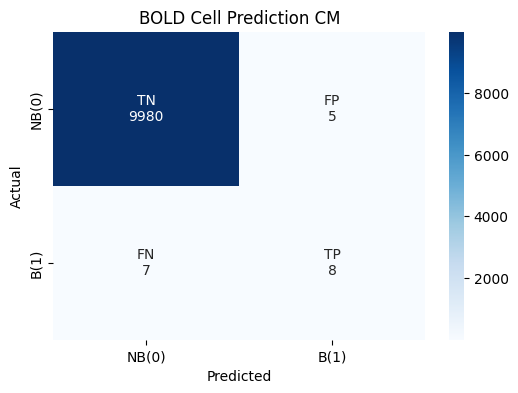


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,8,10,14
0,1,1,1,1,1,1,1,1
1,1,1,0,0,1,1,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,7,8,9,10,11,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



Filename: ../data/50_val/IBACOS_FTP%20Data%20Descriptions.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(13,1): 0.925281 | (17,1): 0.934090 | (1,3): 0.950533 | (6,1): 0.951040 | (1,4): 0.952543 | (2,1): 0.954489 | (1,2): 0.954611 | (1,1): 0.959202

NB to B ratio: Predicted = 9968:32 | Actual = 9992:8
Accuracy: 99.72% | Precision: 18.75% | Recall: 75.00% | F1-Score: 0.30



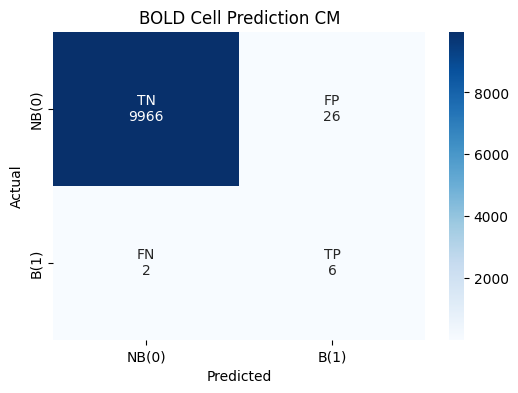


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4
1,1,1,1,1
2,1,0,0,0
3,0,1,0,1
4,0,0,0,1
5,0,1,0,1
6,1,0,0,0
7,0,1,0,1
8,0,1,0,1
9,0,1,0,1
10,1,1,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4
1,1,1,1,1
2,1,0,0,0
6,1,0,0,0
13,1,0,0,0
17,1,0,0,0



Filename: ../data/50_test/darrell_schoolcraft_000_1_1_1.pst.591.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,0): 0.479017 | (3,13): 0.847120 | (4,11): 0.892939 | (3,17): 0.908905 | (4,21): 0.915545 | (4,13): 0.916694 | (3,3): 0.920464 | (4,16): 0.921161 | (5,18): 0.922178 | (0,21): 0.922232 | (0,13): 0.923144 | (1,21): 0.924572 | (0,19): 0.926514 | (4,4): 0.927555 | (0,15): 0.927597 | (4,19): 0.928692 | (0,17): 0.928716 | (1,13): 0.928930 | (5,12): 0.929781 | (0,11): 0.929876 | (4,12): 0.931095 | (1,15): 0.931295 | (1,19): 0.931343 | (3,18): 0.931787 | (1,11): 0.932025 | (4,20): 0.932166 | (1,17): 0.932854 | (4,17): 0.932865 | (4,1): 0.933129 | (3,16): 0.933767 | (4,6): 0.934877 | (0,20): 0.936032 | (2,21): 0.936325 | (0,9): 0.937169 | (0,16): 0.938242 | (4,15): 0.938349 | (1,9): 0.938527 | (2,13): 0.938858 | (0,18): 0.939482 | (4,14): 0.940066 | (4,18): 0.940156 | (3,12): 0.940220 | (4,8): 0.940336 | (0,7): 0.940809 | (2,15): 0.940812 | (4,3): 0.941554 | (1,7): 0.94162

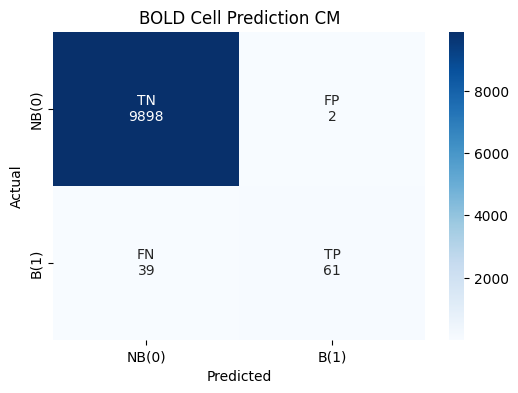


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20
0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,1,0,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [13]:
# Params
loc = 1
thresh = 0.93

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    config=config,
    disp_sig=True,
)
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    config=config,
    disp_sig=True,
)
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    config=config,
    disp_sig=True,
)

Batch Inference: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 399147:853 | Actual = 399199:801
Accuracy: 99.76% | Precision: 33.82% | Recall: 42.42% | F1-Score: 0.33



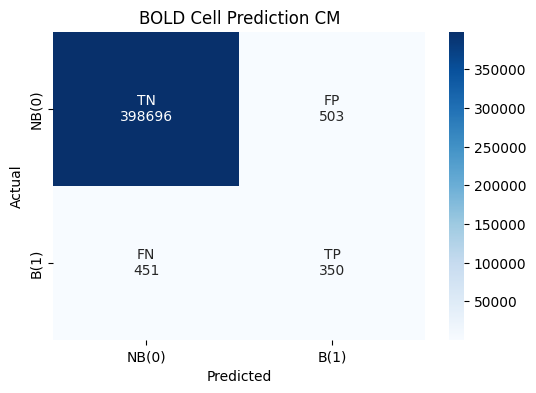

Batch Inference: 100%|██████████| 3/3 [00:00<00:00, 10.20it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49843:157 | Actual = 49846:154
Accuracy: 99.78% | Precision: 59.44% | Recall: 67.80% | F1-Score: 0.57



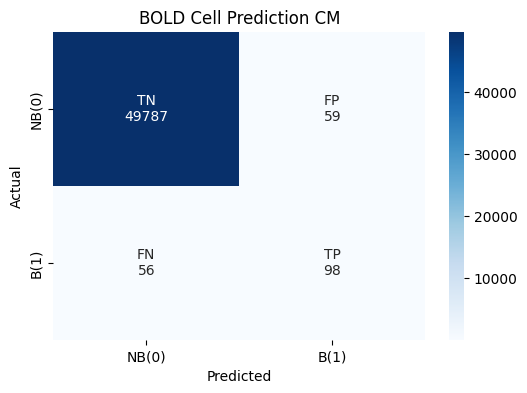

Batch Inference: 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49754:246 | Actual = 49801:199
Accuracy: 99.52% | Precision: 33.21% | Recall: 34.85% | F1-Score: 0.32



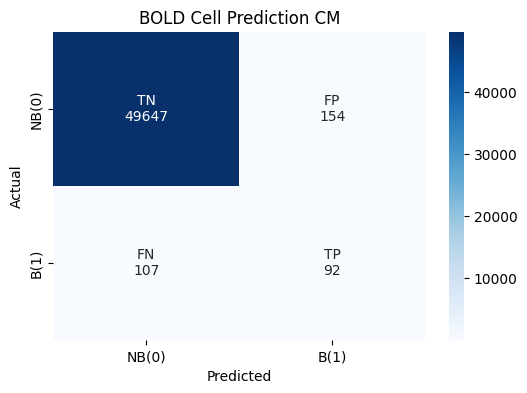

In [14]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=config,
)

# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=config,
)

# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=config,
)